<a href="https://colab.research.google.com/github/gentlelentil/FMP_Cheminformatics_2022/blob/main/ProjektCP_MethodCourse_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import and Configure Everything We Need

In [1]:
!curl -L bit.ly/rdkit-colab | tar xz -C /

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   163  100   163    0     0   1455      0 --:--:-- --:--:-- --:--:--  1455
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 29.6M  100 29.6M    0     0   9.9M      0  0:00:02  0:00:02 --:--:-- 12.9M


In [4]:
!git clone https://github.com/KrishnaswamyLab/PHATE
!cd PHATE/Python ; python setup.py install --user

Finished


 **After first time installing the PHATE package, you need to restart the runtime enviroment !!!**

In [1]:
#%matplotlib inline
from collections import defaultdict as ddict
from copy import deepcopy as copy
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import SVG
import rdkit
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DSVG
from rdkit.Chem.rdmolops import SanitizeFlags
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.cluster import KMeans
import sys
from mpl_toolkits.mplot3d import Axes3D
import joblib
import phate#github
# Set the RDKit logging level to CRITICAL, because 
# lot of RDKit errors occur during the extraction of the 
# fragments. However, the corresponding molecules are 
# corrected in the further course.
RDLogger.logger().setLevel(RDLogger.CRITICAL)

# In many cases NaN
not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']

# Create a descriptor calculator for all RDKit descriptors except the ones above
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])

## Defining Helpful Functions

In [ ]:
#@title
def calc_stats_str(pka1, pka2):
    """Calculates R² score and MAE for two iterables of floats or integers"""
    assert len(pka1) == len(pka2), "Both iterables must have the same length"
    return f'R²: {np.round(r2_score(pka1, pka2), 3)}\n' \
           f'MAE: {np.round(mean_absolute_error(pka1, pka2), 3)}'

def mol_to_svg(mol_, mol_size=(350,200), kekulize=True, highlight_atoms=(), highlight_atom_color=(0,1,0)):
    """Draws a molecule as SVG and optionally highlights atoms in the specified color"""
    mc = copy(mol_)
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except ValueError:
            pass
    if not mc.GetNumConformers():
        Chem.Compute2DCoords(mc)
    drawer = MolDraw2DSVG(*mol_size)
    drawer.DrawMolecule(mc, 
                        highlightAtoms=highlight_atoms, 
                        highlightAtomColors=dict(zip(highlight_atoms, [highlight_atom_color] * len(highlight_atoms))))
    drawer.FinishDrawing()
    return SVG(drawer.GetDrawingText())

def remove_aromatization(mol_):
    """Removes aromatization for every atom in a molecule"""
    for aa in mol_.GetAromaticAtoms():
        aa.SetIsAromatic(False)

def extract_env(mol_, atom_ix, radius):
    """Extract a fragment out of a molecule around the given atom index with the given radius"""
    bond_ix = Chem.FindAtomEnvironmentOfRadiusN(mol_, radius, atom_ix)
    if len(bond_ix) == 0:
        return None
    atom_ix_set = set()
    for bix in bond_ix:
        b = mol_.GetBondWithIdx(bix)
        atom_ix_set.add(b.GetBeginAtomIdx())
        atom_ix_set.add(b.GetEndAtomIdx())
    return Chem.MolFromSmiles(Chem.MolFragmentToSmiles(mol_, atom_ix_set, bond_ix), sanitize=False)

def get_atom_env_mol(mol_, atom_ix, radius):
    """Calls 'extract_env()' with the given parameters and try to solve occurring problems"""
    um = None
    r = radius
    # Try to extract the molecule. If the radius is higher than
    # maximum possible binding length in the given molecule, the
    # 'FindAtomEnvironmentOfRadiusN' returns None. Therefore
    # the radius is lowered until we get a mol object.
    while um is None and r > 0:
        um = extract_env(mol_, atom_ix, r)
        r -= 1
    if um is None:
        raise ValueError('No environment extractable')
        
    r = radius + 1
    not_sanitized = Chem.SanitizeMol(um, catchErrors=True)
    # Fragment have to be sanitized to calculate all descriptors
    # without errors or strange values
    while not_sanitized:
        # This happens if the extraction of the fragment breaks
        # an aromatic ring. After removing the aromatization
        # flags manually from all atoms sanitization is possible.
        # During the sanitization the aromatization flags are
        # corrected automatically again.
        if not_sanitized == SanitizeFlags.SANITIZE_KEKULIZE:
            remove_aromatization(um)
        # In this case the extraction broke something in a not
        # correctable way. Then a new fragment with a higher radius
        # have to be extracted.
        elif not_sanitized == SanitizeFlags.SANITIZE_PROPERTIES:
            um = extract_env(mol_, atom_ix, r)
            r += 1
        not_sanitized = Chem.SanitizeMol(um, catchErrors=True)
    return um

def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))

In [ ]:
thermo_cycle=pd.read_csv("cp/geometric/mc/raw/mc_profiles.csv")#cycle_dpka_filt_full_1 #"/content/drive/My Drive/Master+/THERMODYN_CYCLE/files/cycle_8filt_feat_tzvp.csv"
#thermo_cycle.index=thermo_cycle.No

print("New filter ind")
conv=[268,24952, 26093,3426]

thermo_cycle=thermo_cycle[~thermo_cycle.index.isin(conv)]
filter_ind=list(thermo_cycle.index)
thermo_cycle.describe()


New filter ind


,Unnamed: 0,plate_dim,pert_dose,pert_time,pvalue_activity,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Variance_ER_3,Nuclei_Texture_Variance_ER_5,Nuclei_Texture_Variance_Hoechst_3,Nuclei_Texture_Variance_Hoechst_5,Nuclei_Texture_Variance_Mito_3,Nuclei_Texture_Variance_Mito_5,Nuclei_Texture_Variance_Ph_golgi_3,Nuclei_Texture_Variance_Ph_golgi_5,Nuclei_Texture_Variance_Syto_3,Nuclei_Texture_Variance_Syto_5
count,30115.000000,30115.0,30115.000000,30115.0,30115.000000,30115.000000,30115.000000,30115.000000,30115.000000,30115.000000,...,30115.000000,30115.000000,30115.000000,30115.000000,30115.000000,30115.000000,30115.000000,30115.00000,30115.000000,30115.000000
mean,15059.182534,384.0,9.921204,48.0,0.176236,0.300766,0.364144,0.072638,-0.172267,-0.294475,...,0.324921,0.281292,0.525804,0.496405,0.116272,0.082562,0.240465,0.22209,0.218646,0.215887
std,8694.232571,0.0,1.514377,0.0,0.244482,5.447259,3.139250,1.354339,2.116645,3.804907,...,2.581345,2.405691,3.960102,3.734779,2.599140,2.473697,2.456545,2.32214,2.322064,2.245458
min,0.000000,384.0,0.000000,48.0,0.000000,-38.640000,-20.360000,-33.030000,-34.645000,-53.100000,...,-10.600000,-9.884000,-55.610000,-56.600000,-24.587500,-22.737500,-12.830000,-13.16000,-30.520000,-30.017500
25%,7530.500000,384.0,10.000000,48.0,0.002000,-1.500300,-0.781800,-0.539150,-0.936450,-2.207900,...,-0.944600,-0.860250,-1.722350,-1.595000,-1.069550,-0.977850,-1.005650,-0.92355,-0.851200,-0.798600
50%,15059.000000,384.0,10.000000,48.0,0.051000,-0.052500,-0.016900,0.001600,-0.004100,-0.067800,...,-0.019400,-0.011900,-0.043300,-0.014800,-0.000700,-0.014300,0.020900,0.03150,0.052000,0.052200
75%,22587.500000,384.0,10.043800,48.0,0.269000,1.495300,0.799900,0.559900,0.878500,1.937000,...,1.033700,0.938050,2.159650,2.037750,1.134000,0.976950,1.156900,1.07615,1.039750,0.990850
max,30118.000000,384.0,50.000000,48.0,1.000000,616.270300,81.635000,16.250000,29.046700,40.530000,...,85.330000,79.880000,63.420000,62.090000,90.900000,94.230000,84.220000,84.60000,55.450000,56.500000


## Loading raw Datasets

Initial: 30119


,Unnamed: 0,cell_id,plate_dim,plate_name,plate_well,BROAD_ID,BROAD_CPD_ID,pert_dose,pert_dose_unit,pert_time,pert_time_unit,pvalue_activity,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_3_3,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_4_2,Cells_AreaShape_Zernike_4_4,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_5_3,Cells_AreaShape_Zernike_5_5,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_6_4,Cells_AreaShape_Zernike_6_6,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_3,Cells_AreaShape_Zernike_7_5,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_8_0,Cells_AreaShape_Zernike_8_2,Cells_AreaShape_Zernike_8_4,Cells_AreaShape_Zernike_8_6,Cells_AreaShape_Zernike_8_8,Cells_AreaShape_Zernike_9_1,Cells_AreaShape_Zernike_9_3,Cells_AreaShape_Zernike_9_5,Cells_AreaShape_Zernike_9_7,Cells_AreaShape_Zernike_9_9,Cells_Intensity_IntegratedIntensityEdge_ER,Cells_Intensity_IntegratedIntensityEdge_Hoechst,Cells_Intensity_IntegratedIntensityEdge_Mito,Cells_Intensity_IntegratedIntensityEdge_Ph_golgi,Cells_Intensity_IntegratedIntensityEdge_Syto,Cells_Intensity_IntegratedIntensity_ER,Cells_Intensity_IntegratedIntensity_Hoechst,Cells_Intensity_IntegratedIntensity_Mito,Cells_Intensity_IntegratedIntensity_Ph_golgi,Cells_Intensity_IntegratedIntensity_Syto,Cells_Intensity_LowerQuartileIntensity_ER,Cells_Intensity_LowerQuartileIntensity_Hoechst,Cells_Intensity_LowerQuartileIntensity_Mito,Cells_Intensity_LowerQuartileIntensity_Ph_golgi,Cells_Intensity_LowerQuartileIntensity_Syto,Cells_Intensity_MassDisplacement_ER,Cells_Intensity_MassDisplacement_Hoechst,Cells_Intensity_MassDisplacement_Mito,Cells_Intensity_MassDisplacement_Ph_golgi,Cells_Intensity_MassDisplacement_Syto,Cells_Intensity_MaxIntensityEdge_ER,Cells_Intensity_MaxIntensityEdge_Hoechst,Cells_Intensity_MaxIntensityEdge_Mito,Cells_Intensity_MaxIntensityEdge_Ph_golgi,Cells_Intensity_MaxIntensityEdge_Syto,Cells_Intensity_MaxIntensity_ER,Cells_Intensity_MaxIntensity_Hoechst,Cells_Intensity_MaxIntensity_Mito,Cells_Intensity_MaxIntensity_Ph_golgi,Cells_Intensity_MaxIntensity_Syto,Cells_Intensity_MeanIntensityEdge_ER,Cells_Intensity_MeanIntensityEdge_Hoechst,Cells_Intensity_MeanIntensityEdge_Mito,Cells_Intensity_MeanIntensityEdge_Ph_golgi,Cells_Intensity_MeanIntensityEdge_Syto,Cells_Intensity_MeanIntensity_ER,Cells_Intensity_MeanIntensity_Hoechst,Cells_Intensity_MeanIntensity_Mito,Cells_Intensity_MeanIntensity_Ph_golgi,Cells_Intensity_MeanIntensity_Syto,Cells_Intensity_MedianIntensity_ER,Cells_Intensity_MedianIntensity_Hoechst,Cells_Intensity_MedianIntensity_Mito,Cells_Intensity_MedianIntensity_Ph_golgi,Cells_Intensity_MedianIntensity_Syto,Cells_Intensity_MinIntensityEdge_ER,Cells_Intensity_MinIntensityEdge_Hoechst,Cells_Intensity_MinIntensityEdge_Mito,Cells_Intensity_MinIntensityEdge_Ph_golgi,Cells_Intensity_MinIntensityEdge_Syto,Cells_Intensity_MinIntensity_ER,Cells_Intensity_MinIntensity_Hoechst,Cells_Intensity_MinIntensity_Mito,Cells_Intensity_MinIntensity_Ph_golgi,Cells_Intensity_MinIntensity_Syto,Cells_Intensity_StdIntensityEdge_ER,Cells_Intensity_StdIntensityEdge_Hoechst,Cells_Intensity_StdIntensityEdge_Mito,Cells_Intensity_StdIntensityEdge_Ph_golgi,Cells_Intensity_StdIntensityEdge_Syto,Cells_Intensity_StdIntensity_ER,Cells_Intensity_StdIntensity_Hoechst,Cells_Intensity_StdIntensity_Mito,Cells_Intensity_StdIntensity_Ph_golgi,Cells_Intensity_StdIntensity_Syto,Cells_Intensity_UpperQuartileIntensity_ER,Cells_Intensity_UpperQuartileIntensity_Hoechst,Cells_Intensity_UpperQuartileIntensity_Mito,Cells_Intensity_UpperQuartileIntensity_Ph_golgi,Cells_Intensity_UpperQuartil
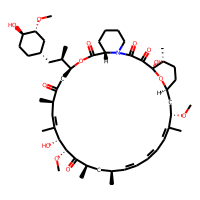
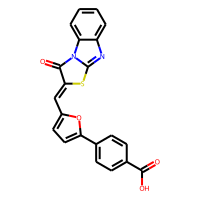

In [ ]:

sdf_path="cp/geometric/mc/raw/compounds1.sdf"
all_df = PandasTools.LoadSDF(sdf_path)#.astype(dict(dG=float, atom=int, dG_CX=float), copy=False)
print(f'Initial: {len(all_df)}')
conv=[268,24952, 26093,3426]

all_df=all_df[~all_df.index.isin(conv)]
show(all_df.head(2))

,smiles,CID,MeSH_Class,Total Number of Classifications,Other Classifications,Complexity,Toxicity,Total Number of Toxicity Records,Other Toxicity,ATC,UNII,ID,ROMol
0,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,99719686,nan,nan,nan,1760,nan,nan,nan,nan,nan,,

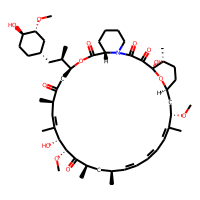

In [ ]:
anno = PandasTools.LoadSDF("cp/annotated/sdfs/result_compounds1.sdf")
anno.head(1)

In [ ]:
b36_molcs=pd.read_csv("cp/b36/b36_molcs_ids.csv",index_col=0)

In [ ]:
baseline=all_df.merge(b36_molcs,how="inner",left_on="BROAD_CPD_ID",right_on="Metadata_pert_id")

In [ ]:
filt_nan=False
if filt_nan:
    anno=anno[anno["MeSH_Class"].astype(str)!="nan"]
anno["smiles_key"]= anno["ROMol"].map(lambda i : Chem.MolToSmiles(i))
all_df["smiles_key"]= all_df["ROMol"].map(lambda i : Chem.MolToSmiles(i))

In [ ]:
baseline_anno_long=all_df.merge(anno,how="inner",left_on="smiles_key",right_on="smiles_key")
baseline_anno_long["MeSHCategorical"]=baseline_anno_long["MeSH_Class"].astype('category')
baseline_anno_long["MeSHCategorical_codes"] = baseline_anno_long["MeSHCategorical"].cat.codes
len(baseline_anno_long)

30521

In [ ]:
all_df=baseline_anno_long.copy()
baseline_anno_long.iloc[2,11:812+12]

pvalue_activity                         0.038
Cells_AreaShape_Area                  -6.5545
Cells_AreaShape_Compactness            2.0875
Cells_AreaShape_Eccentricity            2.606
Cells_AreaShape_Extent                -1.4619
                                       ...   
Nuclei_Texture_Variance_Mito_5        -0.9397
Nuclei_Texture_Variance_Ph_golgi_3     0.4627
Nuclei_Texture_Variance_Ph_golgi_5     0.6202
Nuclei_Texture_Variance_Syto_3        -3.1443
Nuclei_Texture_Variance_Syto_5        -2.5845
Name: 2, Length: 813, dtype: object

## Prepare Fragments for All Molecules and Different Radii

In [ ]:
min_radius = 3 # inclusive
max_radius = 5 # exclusive, is also the key for the complete molecule
radii = list(range(min_radius, max_radius))

In [ ]:
all_df["ROMol"]=all_df.ROMol_y

30521


,ROMol_y,MeSHCategorical,MeSHCategorical_codes,frag_R3,frag_R4
0,,nan,253,,

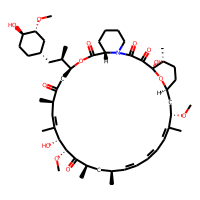
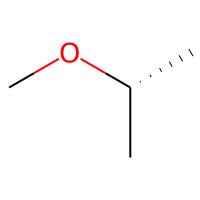
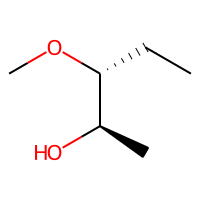

In [ ]:
frags = ddict(list)

for _, row in all_df.iterrows():
    aix = 0#int(row.atom) fragment around first atom
    mol = row.ROMol_y
    for i in radii:
      try:
        frags[i].append(get_atom_env_mol(mol, aix, i))
      except:
        print(_)

for i in radii:
    all_df[f'frag_R{i}'] = frags[i]
print(len(all_df))
show(all_df.iloc[:1,-5:])
#all_df.iloc[0,-5:]

In [ ]:
rdkit.Chem.rdMolDescriptors.CalcExactMolWt(all_df["ROMol"][0])

913.5551415880002

In [ ]:
all_df["MWt"]=all_df["ROMol"].apply(rdkit.Chem.rdMolDescriptors.CalcExactMolWt)
all_df["FrCSP3"]=all_df["ROMol"].apply(rdkit.Chem.rdMolDescriptors.CalcFractionCSP3)
all_df["NumArHetCyc"]=all_df["ROMol"].apply(rdkit.Chem.rdMolDescriptors.CalcNumAromaticHeterocycles)
all_df["NumHet"]=all_df["ROMol"].apply(rdkit.Chem.rdMolDescriptors.CalcNumHeteroatoms)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


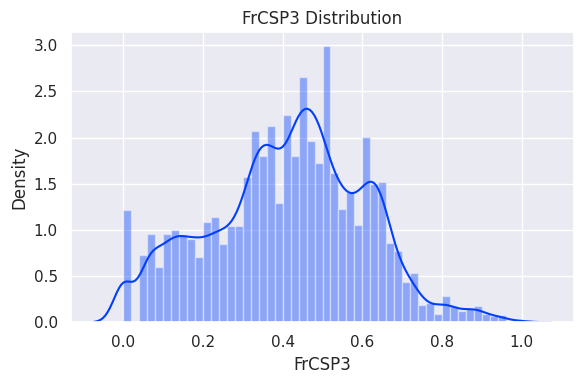

In [ ]:
sns.set(palette='bright')
plt.figure(dpi=100)
sns.distplot(all_df.FrCSP3)
plt.ylabel('Density')
plt.xlabel('FrCSP3')
plt.title('FrCSP3 Distribution')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


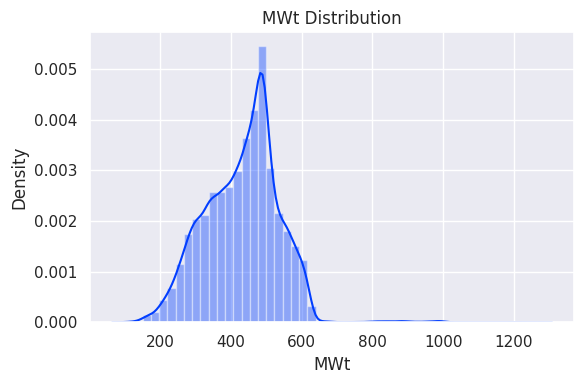

In [ ]:
sns.set(palette='bright')
plt.figure(dpi=100)
sns.distplot(all_df.MWt)
plt.ylabel('Density')
plt.xlabel('MWt')
plt.title('MWt Distribution')
plt.tight_layout()
plt.show()

## Calculating Descriptors and Fingerprints for All Fragments and Different Radii

In [ ]:
keys = radii + [max_radius]
descs = ddict(list)
for _, row in all_df.iterrows():
    for i in keys:
        mol = row.ROMol if i == max_radius else row[f'frag_R{i}']
        descs[i].append(desc_calc.CalcDescriptors(mol))

In [ ]:
# Default 2048 bits for all fps
morgan0 = ddict(list)
morgan1 = ddict(list)
morgan2 = ddict(list)
morgan3 = ddict(list)
topol = ddict(list)
atpair = ddict(list)

for _, row in all_df.iterrows():
    for i in keys:
        mol = row.ROMol if i == max_radius else row[f'frag_R{i}']
        morgan0[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=0))
        morgan1[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=1))
        morgan2[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=2))
        morgan3[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=3))
        topol[i].append(Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol))
        atpair[i].append(Chem.GetHashedAtomPairFingerprintAsBitVect(mol))

In [ ]:
#PandasTools.WriteSDF(all_df,"processed_sdf",properties=all_df.columns)

## Clustering and Visualization of data

In [ ]:
data=all_df.iloc[:,11:812+12]#.dropna()

30521
30


/home/davidb/anaconda3/envs/pyg/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


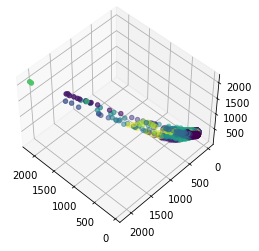

In [ ]:
print(len(data))
X=kmeans.transform(data)
#X=test_dfX.iloc[:][:12]
print(k)
fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[:, 0], X[:, 1],X[:, 3], c=pred)
#ax.dist = 12
#ax.scatter(X[:, 3], X[:, 0], X[:, 2],c=labels.astype(float), edgecolor='k')


In [ ]:
with open("kpreds.txt", "w+") as g:
  for i in pred:
    g.writelines(str(i)+"\n")

In [ ]:
phate_op2 = phate.PHATE(n_components=3,knn=200,n_jobs=20,random_state=4)
data_phate2 = phate_op2.fit_transform(data)

Calculating PHATE...
  Running PHATE on 30521 observations and 813 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 10.51 seconds.
    Calculating KNN search...
    Calculated KNN search in 62.56 seconds.
    Calculating affinities...


/home/davidb/anaconda3/envs/pyg/lib/python3.7/site-packages/graphtools-1.5.2-py3.7.egg/graphtools/graphs.py:293: RuntimeWarning: Detected zero distance between 406 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  RuntimeWarning,


    Calculated affinities in 6.45 seconds.
  Calculated graph and diffusion operator in 83.26 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 81.67 seconds.
    Calculating KMeans...
    Calculated KMeans in 30.75 seconds.
  Calculated landmark operator in 120.34 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 1.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 79.73 seconds.
Calculated PHATE in 284.63 seconds.


In [ ]:
with open("kpreds.txt", "r") as g:
    pred_copy=g.readlines()

/home/davidb/anaconda3/envs/pyg/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) scatter3d. (Use scprep.plot.scatter3d instead) -- Deprecated since version 1.0.0.
  """Entry point for launching an IPython kernel.


<Axes3DSubplot:>

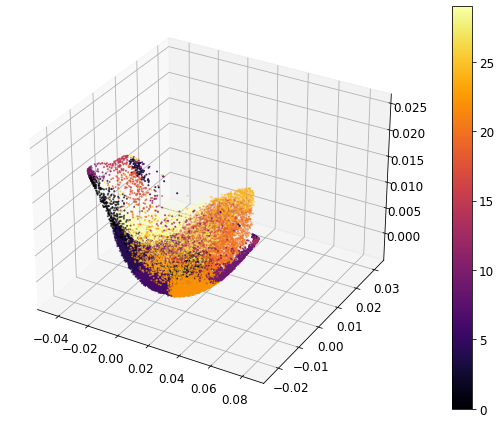

In [ ]:
phate.plot.scatter3d(phate_op2,c=pred,figsize=(12,6),dpi=600)#,lin1_9
#                     filename="phate_model_full_bs1_mc_lr5-5_performer_train.png")

In [ ]:
#pred=[int(i) for i in pred_copy]
test_dfX["Cluster"]=pred

In [ ]:
!sleep 30m

^C


/home/davidb/anaconda3/envs/pyg/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


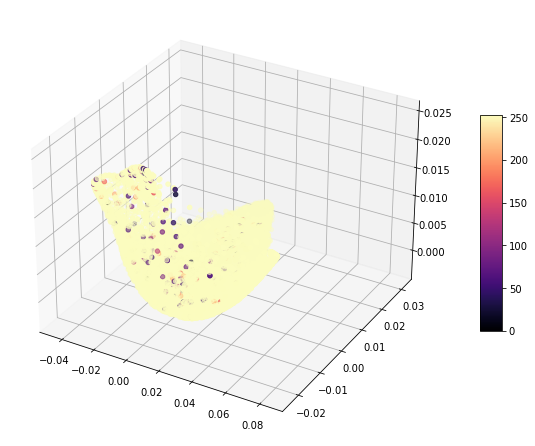

In [ ]:
fig = plt.figure(1, figsize=(12, 6))#
ax1 = Axes3D(fig, rect=[0, 0, .95, 1])
d=ax1.scatter(test_dfX['phate2dim1'], test_dfX['phate2dim2'],test_dfX["phate2dim3"], c=test_dfX["MeSHCategorical_codes"],cmap="magma")
fig.colorbar(d, shrink=0.5, aspect=10)
#plt.savefig("phate2_DMSO.png",dpi=900)

In [ ]:
test_dfX=test_dfX.dropna()
test_dfX["Kluster"]=pred

/home/davidb/anaconda3/envs/pyg/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


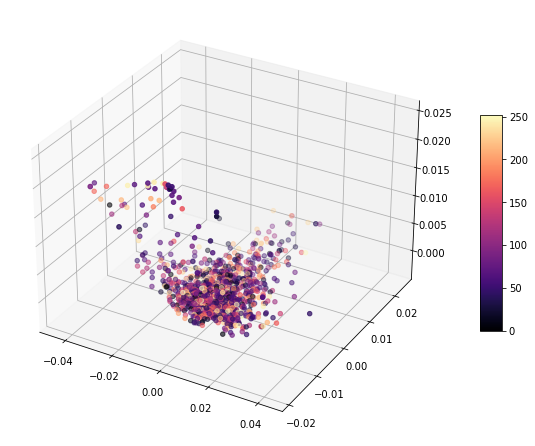

In [ ]:
test_dfX_nonan=test_dfX[test_dfX.MeSH_Class.astype(str)!="nan"].copy()
fig = plt.figure(1, figsize=(12, 6))#
ax1 = Axes3D(fig, rect=[0, 0, .95, 1])
d=ax1.scatter(test_dfX_nonan['phate2dim1'], test_dfX_nonan['phate2dim2'],test_dfX_nonan["phate2dim3"], c=test_dfX_nonan["MeSHCategorical_codes"],cmap="magma")
fig.colorbar(d, shrink=0.5, aspect=10)
#plt.savefig("phate2_DMSO.png",dpi=900)

,Unnamed: 0,cell_id,plate_dim,plate_name,plate_well,BROAD_ID,BROAD_CPD_ID,pert_dose,pert_dose_unit,pert_time,...,ATC,UNII,ID_y,ROMol_y,MeSHCategorical,MeSHCategorical_codes,phate2dim1,phate2dim2,phate2dim3,Cluster
597,596,U2OS,384,C-2113-01-D39-002,J17,BRD-K45071273-003-17-3,BRD-K45071273,10.0,um,48,...,S01HA03,0619F35CGV,,,"Anesthetics, Local",33,-0.005387,-0.002665,-0.002116,27

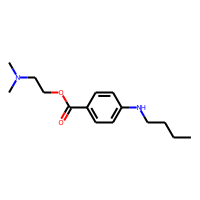

In [ ]:
test_dfX_nonan.head(1)

,Cluster,ROMol_y,MeSH_Class
12223,1,,Adenosine A2 Receptor Antagonists
12346,1,,"Adjuvants, Anesthesia"
12083,1,,"Adjuvants, Immunologic"
11756,1,,Adrenergic Uptake Inhibitors
10555,1,,Adrenergic alpha-1 Receptor Agonists
...,...,...,...
12365,1,,Vasodilator Agents
10981,1,,Vitamins
10356,1,,Voltage-Gated Sodium Channel Blockers
11790,1,,Voltage-Gated Sodium Channel Blockers

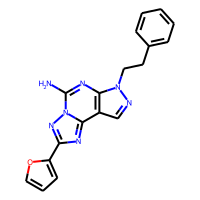
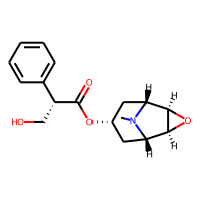
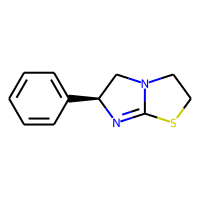
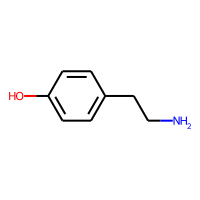
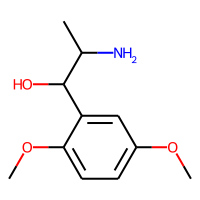
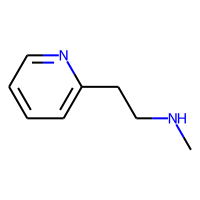
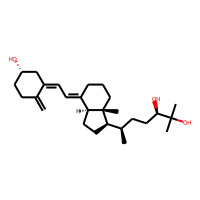
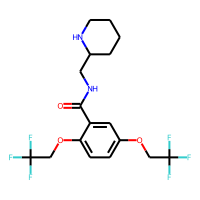
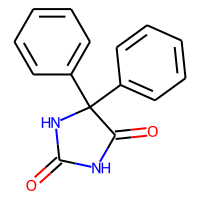
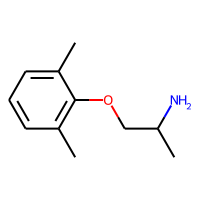

In [ ]:
test_dfX_nonan[["Cluster","ROMol_y","MeSH_Class"]][test_dfX_nonan["Cluster"]==1].sort_values(by=['MeSH_Class'])